In [54]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing, linear_model
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

data = pd.read_csv("..\\CO2_Emissions_Canada.csv", delimiter=',')
data["Vehicle Class"] = data["Vehicle Class"].astype("category")
data["Model"] = data["Model"].astype("category")
data["Make"] = data["Make"].astype("category")
data["Transmission"] = data["Transmission"].astype("category")
print(data.head())

    Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                   

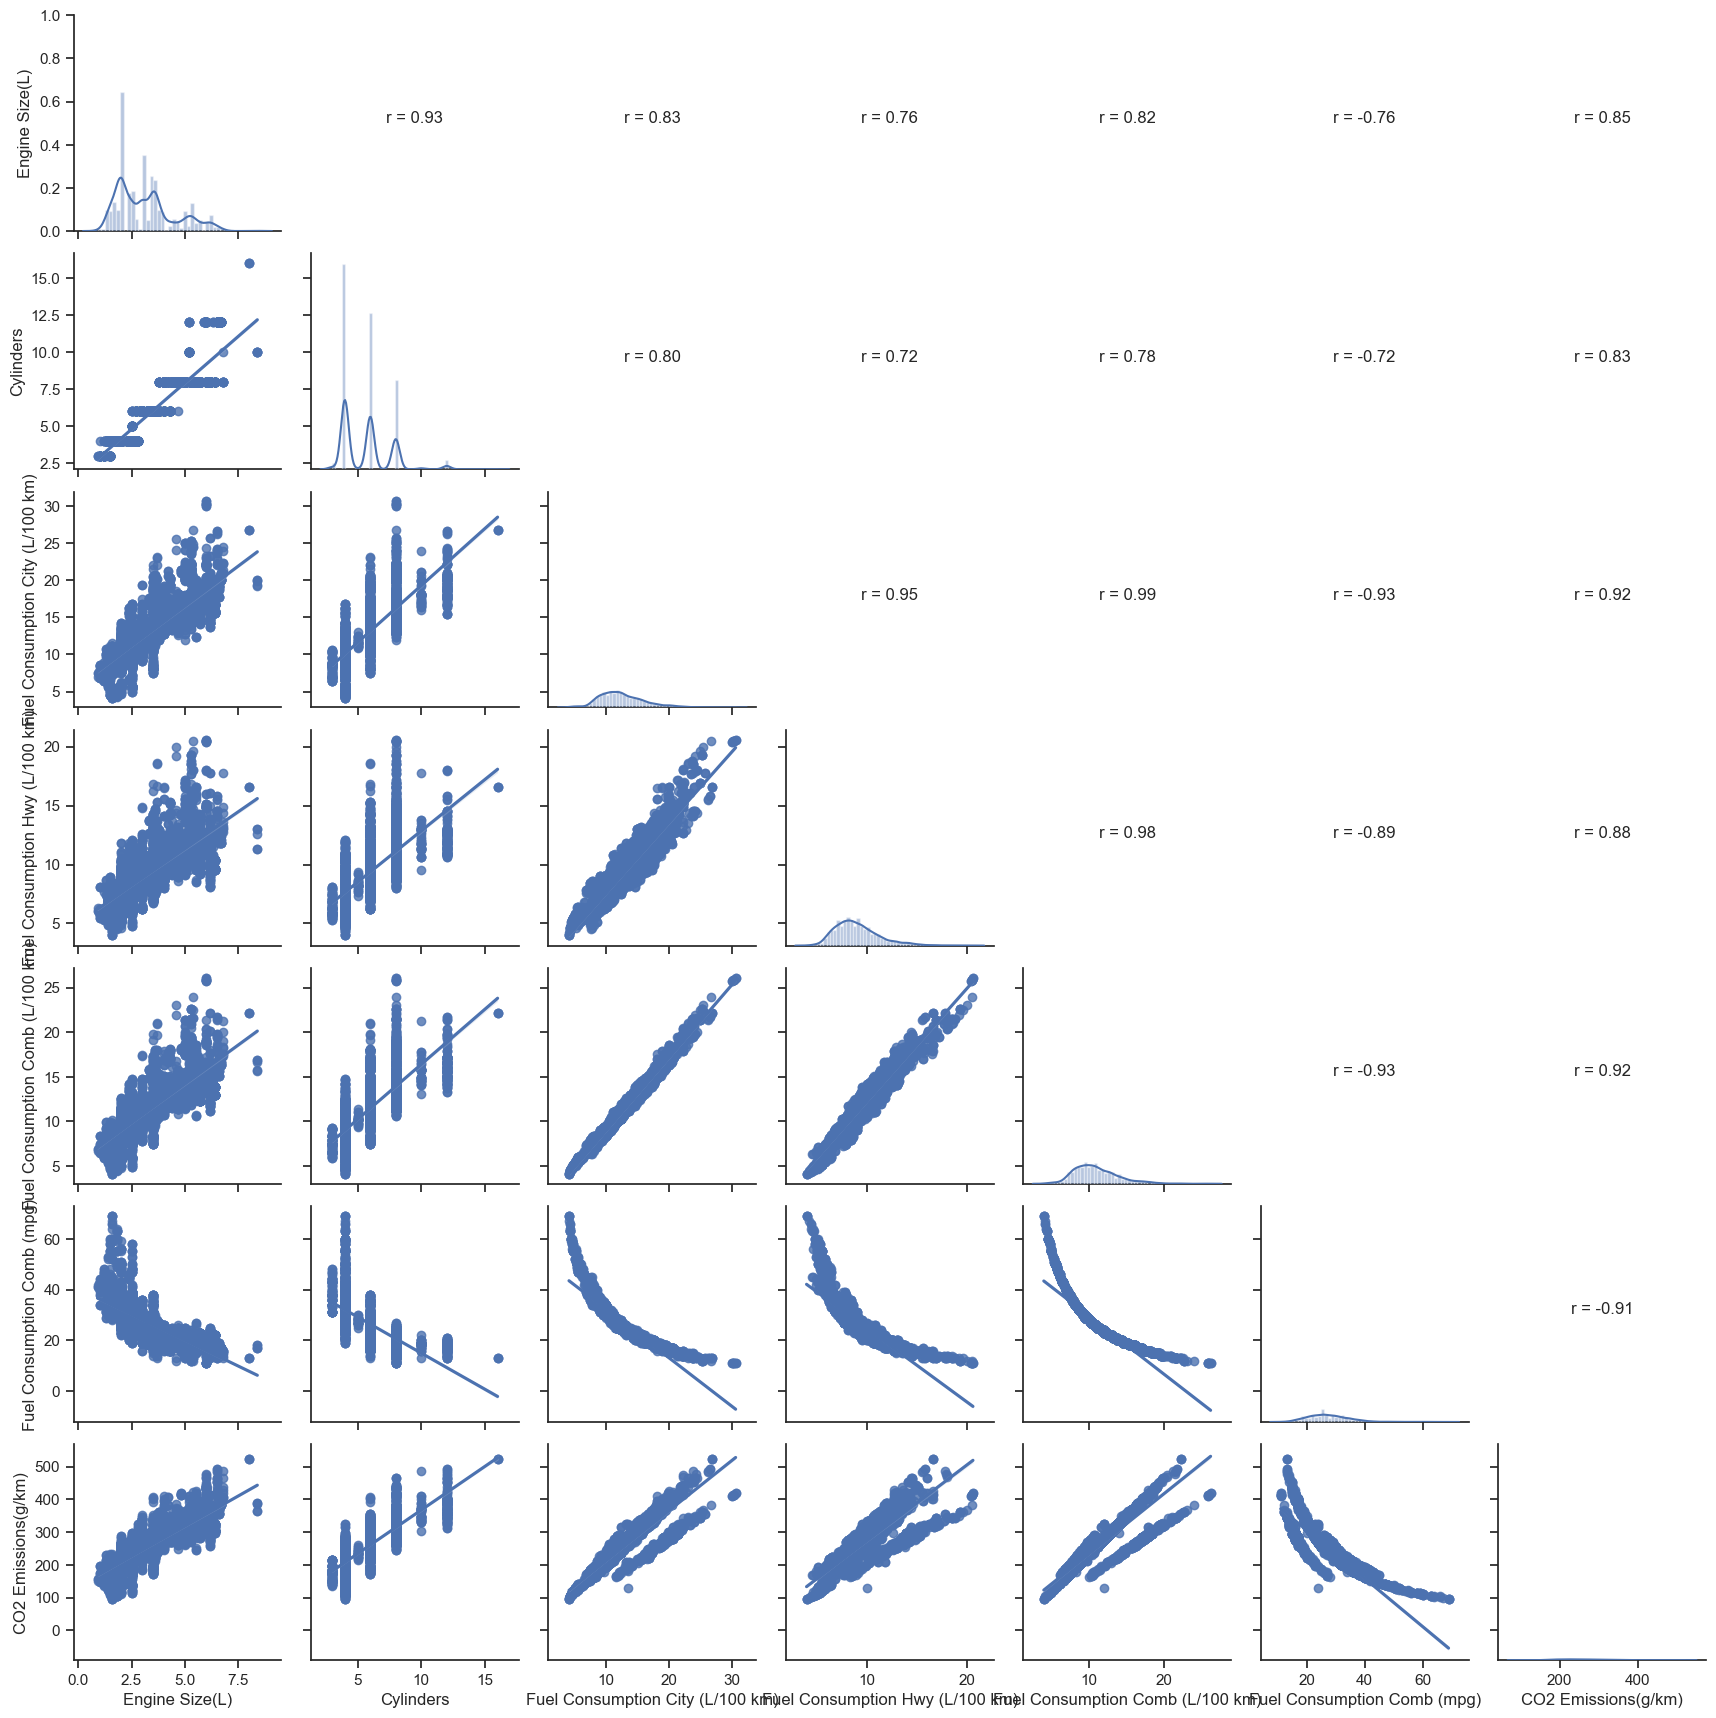

In [55]:
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r, _ = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

sns.set_theme(style="ticks")
g = sns.PairGrid(data, palette=["b", "r", "g", "y", "orange"])
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)
plt.show()

In [56]:
#data transformation
le = preprocessing.LabelEncoder()
data["Make"] = le.fit_transform(data["Make"])
data["Model"] = le.fit_transform(data["Model"])
data["Vehicle Class"] = le.fit_transform(data["Vehicle Class"])
data["Transmission"] = le.fit_transform(data["Transmission"])
data["Fuel Type"] = le.fit_transform(data["Fuel Type"])

In [62]:
#Setting random state for reproducibility
random_state=12345

feature_cols = ['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'Transmission', 'Fuel Type', "Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)", "Fuel Consumption Comb (L/100 km)", "Fuel Consumption Comb (mpg)"]
X = data[feature_cols]
y = data["CO2 Emissions(g/km)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

lgr = linear_model.LinearRegression().fit(X_train, y_train)
lgr_pred = lda.predict(X_test)
lgr_prob = lda.predict_proba(X_test)[:,1]

#lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
#lda_pred = lda.predict(X_test)
#lda_prob = lda.predict_proba(X_test)[:,1]

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)

#scores = cross_val_score(lda, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

print ("Accuracy Score of the model: " + str(round(lgr.score(X_test, y_test), 4)) + "%")

Accuracy Score of the model: 0.9171%


Text(0, 0.5, 'Predictions')

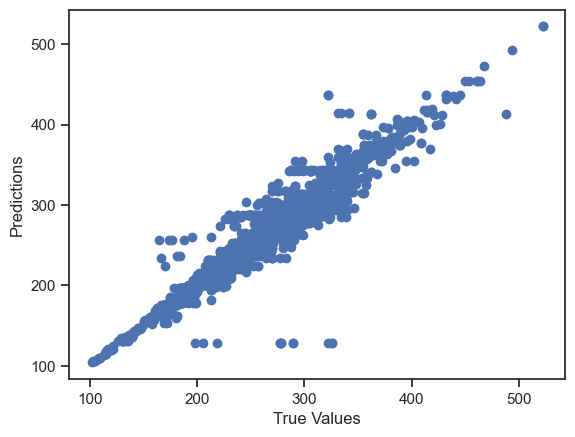

In [63]:
plt.scatter(y_test, lgr_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")